In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [34]:
drive.mount('/content/drive')
filedir = '/content/drive/MyDrive/fwe458/datasets/'
fname = filedir + "SW_with_AOD.csv"

df = pd.read_csv(fname)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
#check for outliers
print("\nSummary statistics:\n", df.describe())


Summary statistics:
                 SZA           AOD           COD      CLD_FRAC            UW  \
count  35224.000000  35224.000000  35224.000000  35224.000000  35224.000000   
mean      43.955300      0.607132      1.386743      0.146884      2.272496   
std       15.444956      0.561003      1.427229      0.136276      1.315785   
min        0.325058      0.001963      0.000031      0.000000      0.093588   
25%       32.476989      0.204275      0.290974      0.037539      1.172140   
50%       45.385958      0.399925      0.809864      0.095963      2.011255   
75%       56.807423      0.830358      2.163631      0.229764      3.218210   
max       69.999329      5.267975     16.270000      0.645196      6.701678   

                TO3      Pressure           BSA           WSA     SW_direct  \
count  35224.000000  35224.000000  35224.000000  35224.000000  35224.000000   
mean     296.895774    958.845881      0.160722      0.173584    450.597469   
std       33.357280     52.63

Part 1: Data Preprocessing

In [36]:
#remove rows with NA values
df = df.dropna()

#add a new column called SW_total
df['SW_total'] = df['SW_direct'] + df['SW_diffuse']

#create new categorical column based on quartiles
df['SW_total_category'] = pd.qcut(df['SW_total'], q=4, labels=["Q1", "Q2", "Q3", "Q4"])

df.head()

SZA       AOD       COD  CLD_FRAC        UW         TO3    Pressure  \
0  24.936783  1.172892  2.440000  0.286546  2.021502  311.419861  959.085083   
1  34.865055  1.626954  4.630000  0.468832  4.859887  308.713379  968.427551   
2  27.330978  1.095007  2.030000  0.301414  5.278558  293.322052  988.040588   
3  20.361732  1.126541  5.500000  0.377019  4.856422  321.498199  977.610229   
4  13.433228  0.725452  0.736076  0.075378  0.644262  295.448975  882.321411   

     BSA    WSA   SW_direct  SW_diffuse     SW_total SW_total_category  
0  0.162  0.193  467.191650  300.820007   768.011658                Q3  
1  0.155  0.169  264.900024  385.293335   650.193359                Q3  
2  0.136  0.149  313.553314  321.538361   635.091675                Q2  
3  0.156  0.179  143.902298  501.073639   644.975937                Q3  
4  0.188  0.212  957.331665   79.003334  1036.334999                Q4

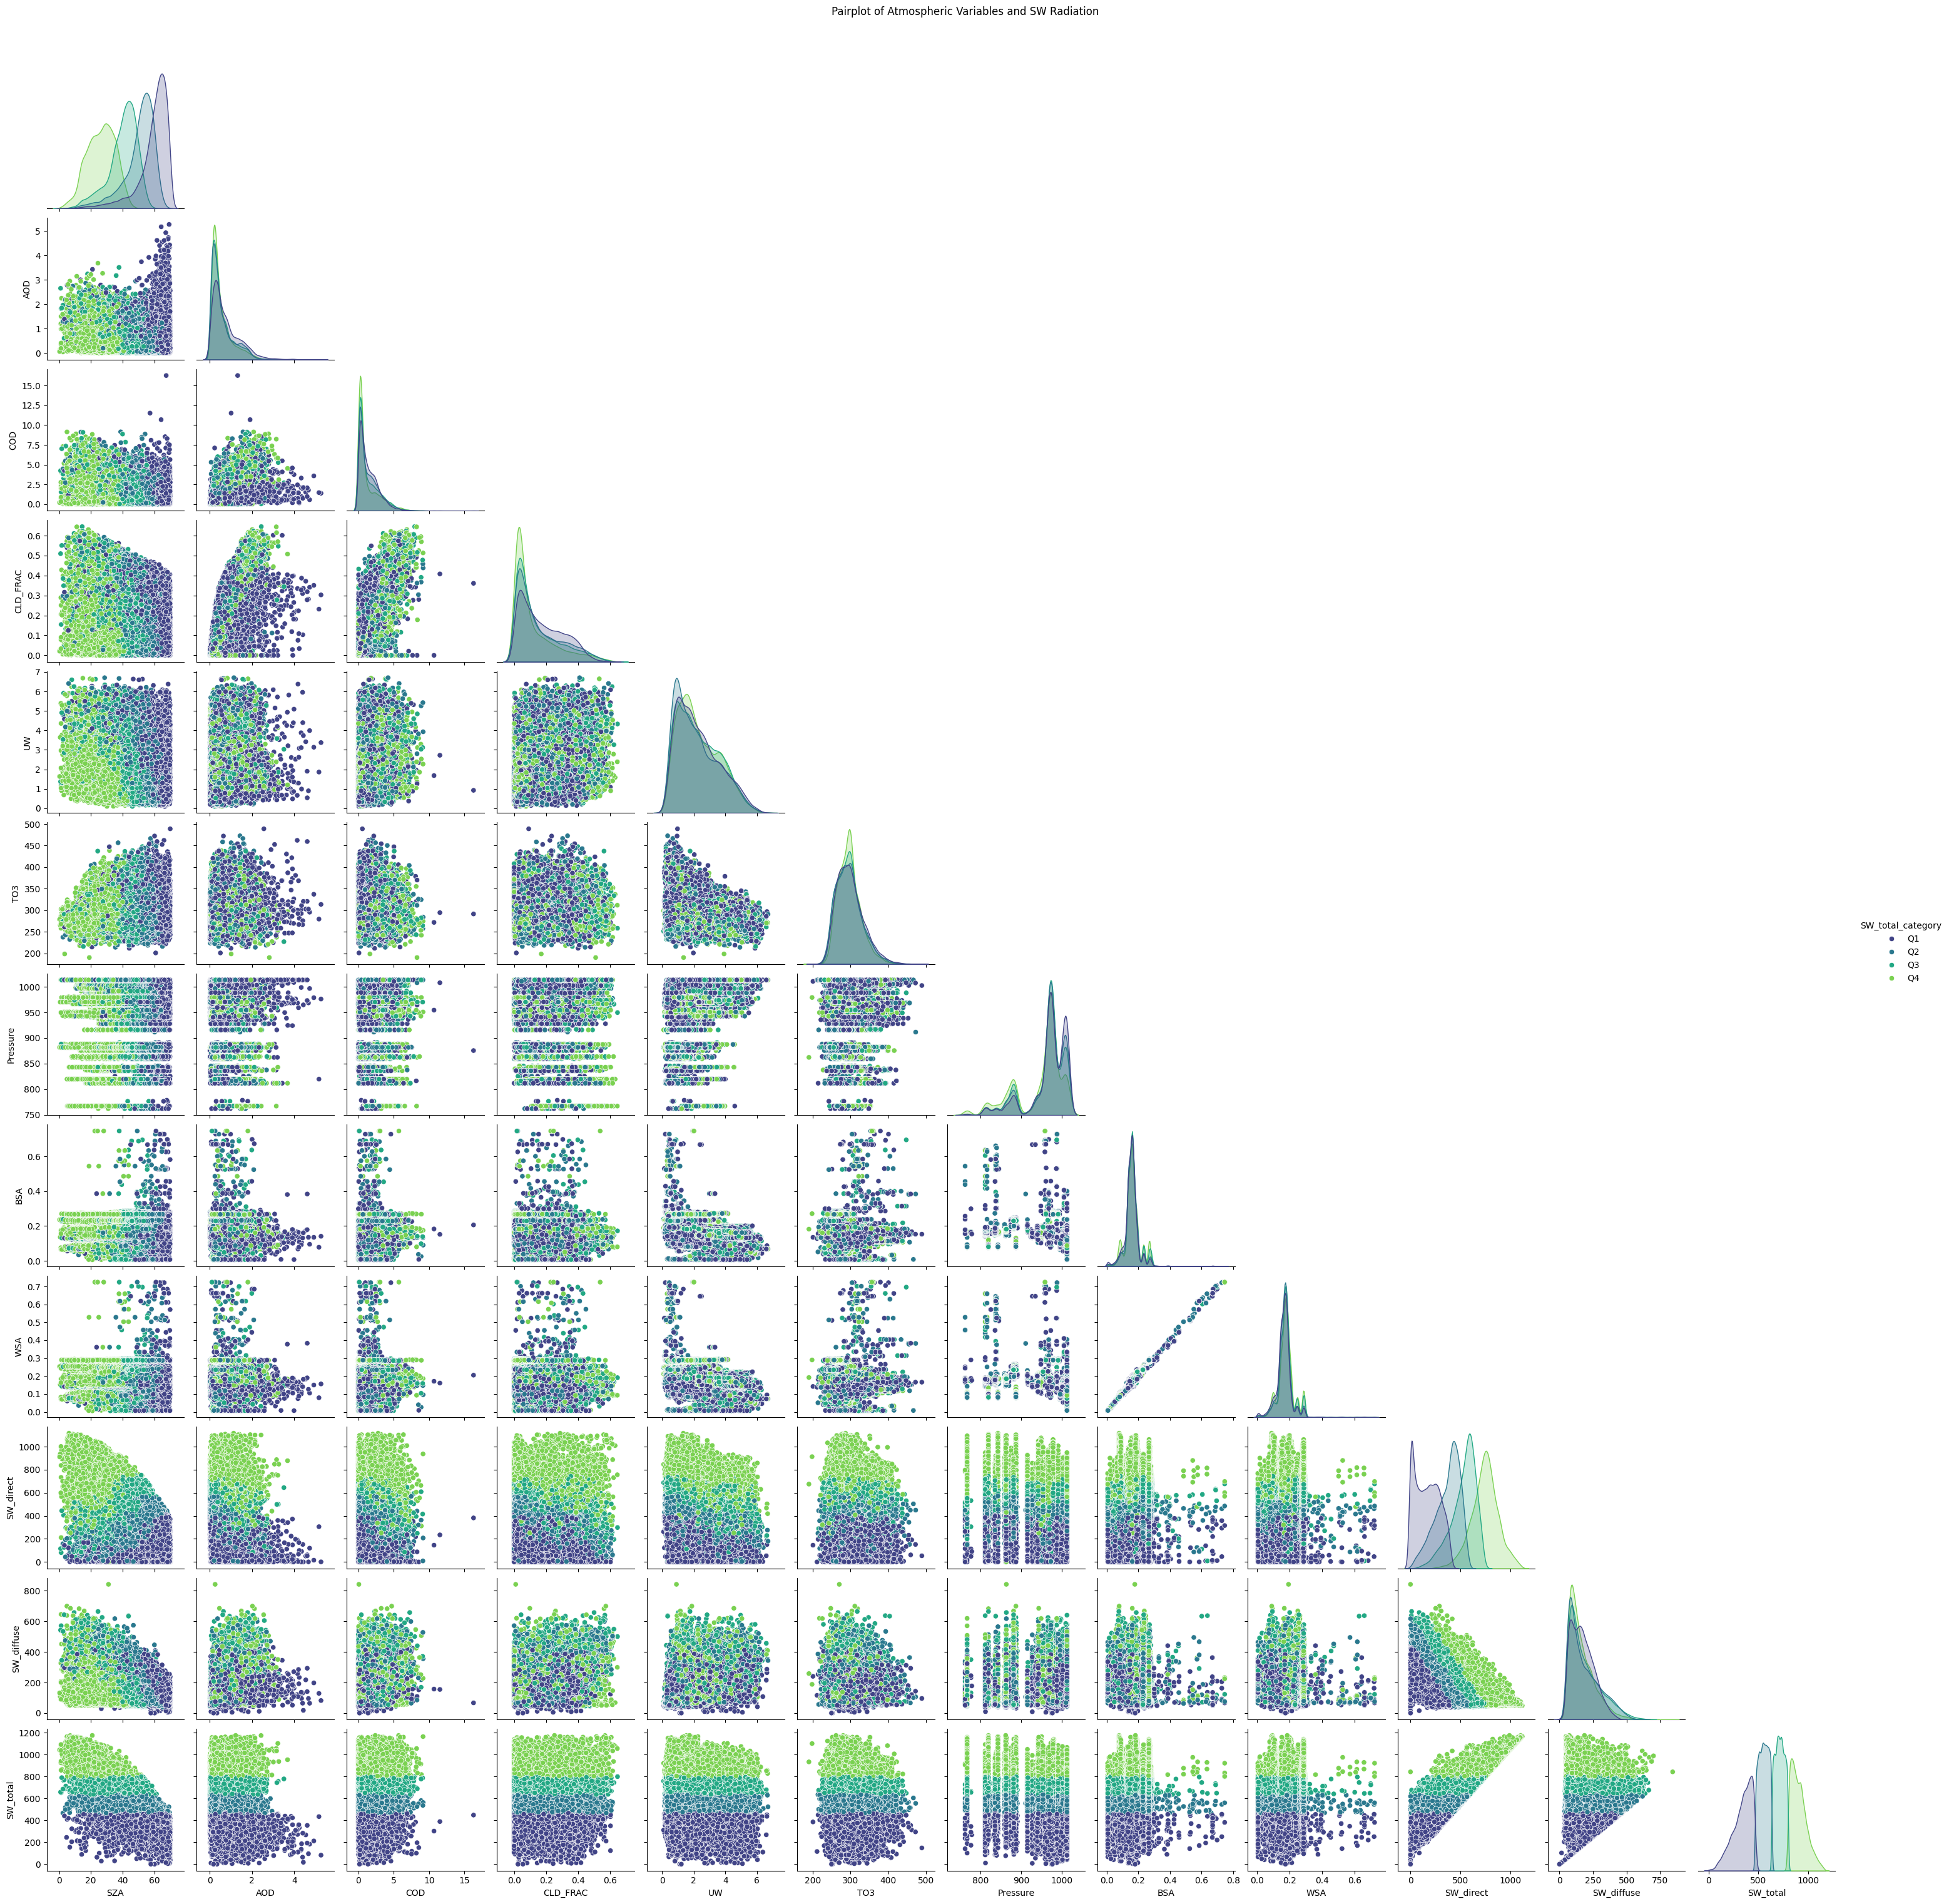

In [10]:
#identify the releveant columns for the pairplot
plot_columns = ['SZA', 'AOD', 'COD', 'CLD_FRAC', 'UW', 'TO3', 'Pressure', 'BSA', 'WSA',
                'SW_direct', 'SW_diffuse', 'SW_total', 'SW_total_category']

#create a subset of the data of only the columns we want
pairplot_data = df[plot_columns]

#create the pairplot
sns.pairplot(pairplot_data, hue="SW_total_category", corner=True)
plt.show()

Part 2: Unsupervised Learning

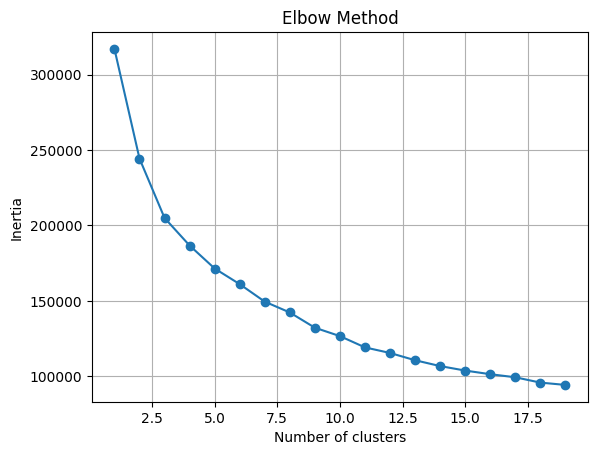

In [37]:
#select input features
input_features = ['SZA', 'AOD', 'COD', 'CLD_FRAC', 'UW', 'TO3', 'Pressure', 'BSA', 'WSA']
X = df[input_features]

#normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


#use the elbow method to determine the optimal k value
inertias = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

#graph the results
plt.plot(range(1, 20), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

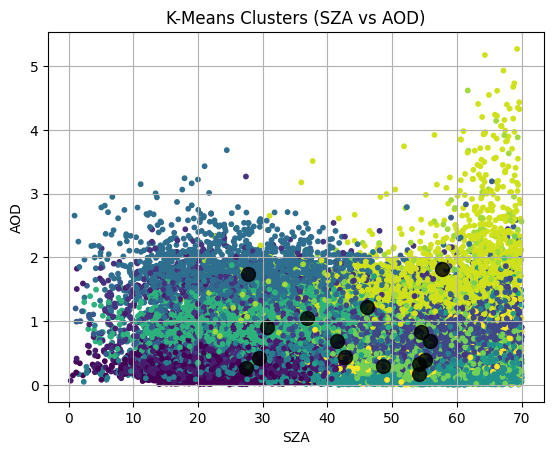

In [46]:
#use 15 clusters after doing the elbow method
kmeans = KMeans(n_clusters=15, random_state=0)
kmeans.fit(X_scaled)
df['Cluster'] = kmeans.predict(X_scaled)

#create a scatter plot
plt.scatter(df['SZA'], df['AOD'], c=df['Cluster'], s=10)
centers = kmeans.cluster_centers_

#Get original feature indices for plotting cluster centers in original scale
sza_idx = input_features.index('SZA')
aod_idx = input_features.index('AOD')

#unscale the centers to make the graph more readable
centers_unscaled = scaler.inverse_transform(centers)

plt.scatter(centers_unscaled[:, sza_idx], centers_unscaled[:, aod_idx],
            c='black', s=100, alpha=0.8)
plt.xlabel('SZA')
plt.ylabel('AOD')
plt.title('K-Means Clusters (SZA vs AOD)')
plt.grid(True)
plt.show()

It is difficult to tell whether the clusters align well with SW_total_category. There are 15 clusters and only 4 categories, so they are not aligned that well. The clusters have a lot of overlap and their centers are grouped in a specific area. These clusters are not meaningful in terms of solar radiation categories.


Part 3: Supervised Learning

In [71]:
#define features and y value
feature_cols = ['SZA', 'AOD', 'COD', 'CLD_FRAC', 'UW', 'TO3', 'Pressure', 'BSA', 'WSA']
X = df[feature_cols]
y = df['SW_total']

# Train/test split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)

#define the model
treemodel = DecisionTreeRegressor(max_depth = 2)

#fit the model
treemodel.fit(Xtrain, ytrain)

#find y values for training and testing
ypred_train = treemodel.predict(Xtrain)
ypred_test = treemodel.predict(Xtest)

#calculate metrics
rmse = np.sqrt(np.mean((ytest-ypred_test)**2))
r2 = r2_score(ytest, ypred_test)

print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)

Root Mean Squared Error (RMSE): 133.86530122668265
R² Score: 0.6371244006073606


In [63]:
#define and fit the model
forest = RandomForestRegressor(100, max_depth=i+1)
forest.fit(Xtrain, ytrain)

#find y values for training and testing
ypred_train = forest.predict(Xtrain)
ypred_test = forest.predict(Xtest)

#calculate metrics
rmse = np.sqrt(np.mean((ytest-ypred_test)**2))
r2 = r2_score(ytest, ypred_test)

print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)

Root Mean Squared Error (RMSE): 99.13130959548913
R² Score: 0.7986243796971236


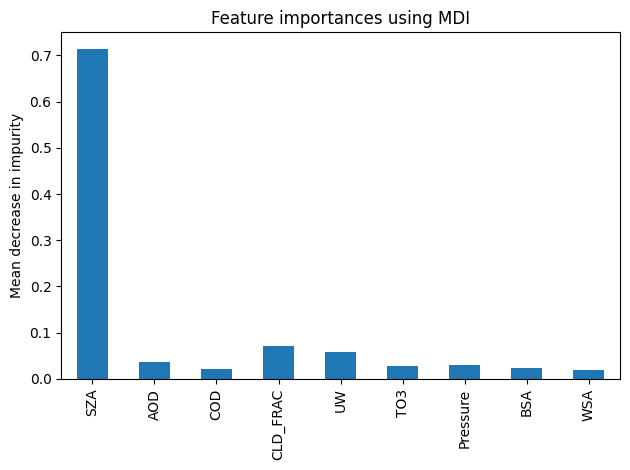

In [65]:
#extract importances
importances = forest.feature_importances_
feature_names = ["SZA", "AOD", "COD", "CLD_FRAC", "UW", "TO3", "Pressure", "BSA", "WSA"]
forest_importances = pd.Series(importances, index=feature_names)

#graph feature importances
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

This graph shows feature importance. The higher the mean decrease in impurity for a feature, the more important it is. SZA (Solar Zenith Angle) was by far the most important, with CLD_FRAC (Cloud Fraction) in second place for mean decrease in impurity.

In [77]:
#identify features and labels
X = df[["SZA", "AOD", "COD", "CLD_FRAC", "UW", "TO3", "Pressure", "BSA", "WSA"]]
y = df['SW_total_category']

#split the dataset
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

#create the model
knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(Xtrain, ytrain)
y_pred_knn = knn.predict(Xtest) #predict values

#print metrics
print("Accuracy:", metrics.accuracy_score(ytest, y_pred_knn))
print("Precision:", metrics.precision_score(ytest, y_pred_knn, average='macro'))
print("Recall:", metrics.recall_score(ytest, y_pred_knn, average='macro'))
print("F1 Score:", metrics.f1_score(ytest, y_pred_knn, average='macro'))

print(metrics.confusion_matrix(ytest, y_pred_knn))

Accuracy: 0.6029808374733854
Precision: 0.6165248127753085
Recall: 0.6026069897969659
F1 Score: 0.603327403729427
[[1370  299   71   24]
 [ 615  852  238   41]
 [ 176  513  917  154]
 [  70  131  465 1109]]


In [82]:
#create the model
gnb = GaussianNB()
gnb.fit(Xtrain, ytrain)
ypred = gnb.predict(Xtest) #predict values

#print metrics
print("Accuracy:", metrics.accuracy_score(ytest, ypred))
print("Precision:", metrics.precision_score(ytest, ypred, average='macro'))
print("Recall:", metrics.recall_score(ytest, ypred, average='macro'))
print("F1 Score:", metrics.f1_score(ytest, ypred, average='macro'))

print(metrics.confusion_matrix(ytest, ypred))

Accuracy: 0.6572036905606813
Precision: 0.6618897529727427
Recall: 0.656831403759655
F1 Score: 0.6585532813176354
[[1244  384  109   27]
 [ 295 1059  297   95]
 [  43  457  957  303]
 [   4    5  396 1370]]


The GaussianNB model performed better because it has higher values for accuracy, precision, recall, and the F1 score.

Part 4: Reflection and Recommendation

After creating these different models and regressors, here is what I have found. Based on the random forest model, the most important features for predicting total shortwave radiation are Solar Zenith Angle, Cloud Fraction, and Water vapor column. Solar Zenith Angle is the most important by far. My clusters did not have clear patterns, and I'm curious if there was a data cleaning issue. I summarized the data to look for outliers and nothing stood out to me as massively wrong, but I ended up with 15 clusters in my Kmeans which seems like too many. Based on my results, I would recommend the Random Forest Regressor for solar radiation prediction. While it wasn't a perfect model, it had an R-squared score of about 0.8, and seemed to perform the best of the models I made.